# Tester notebook for RCC

In [1]:
import xarray as xr
import rioxarray
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import mapping

#from clustering import *
from radially_constrained_cluster import *

/home/jgrassi/miniconda3/lib/python3.11/site-packages/pyogrio/raw.py:196: RuntimeWarning: driver ESRI Shapefile does not support open option CRS
  return ogr_read(


<Axes: >

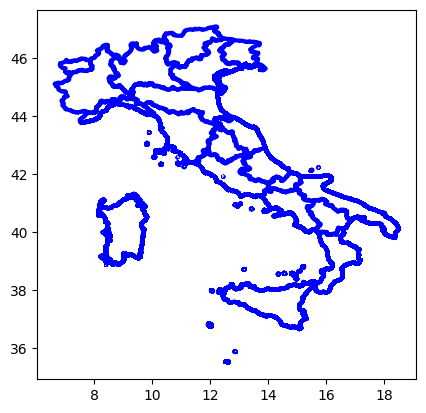

In [2]:
italy_region = gpd.read_file('/work/users/jgrassi/data/italy.shp', crs="epsg:4326")
italy_region.boundary.plot(color = 'b', linewidth = 3, label = 'Regioni')


# abruzzo 1
# puglia 2
# basilicata 3
# calabria 4
# campania 5
# emiliaromagna 6
# friulivg 7
# lazio = 8
# liguria 9 
# lombardia 10
# marche 11
# molise 12
# piemonte 13
# sardegna 14
# sicilia 15
# toscana 16
# trentinoag 17
# umbria 18
# aosta 19
# veneto 20

In [3]:
data_path = '/work/users/jgrassi/data/ERA5'
dataset_t2m_ori = xr.open_mfdataset(rf'{data_path}/2m_temperature/temperature_*.nc')
dataset_t2m_ori = dataset_t2m_ori.convert_calendar('noleap')
dataset_t2m_ori = dataset_t2m_ori.sel(time=slice('1980','2010'))

# dataset_tp_ori = xr.open_mfdataset(rf'{data_path}/total_precipitation/*.nc')
# dataset_tp_ori = dataset_tp_ori.convert_calendar('noleap').rolling(time=10*24, center=True).mean()

# dataset_ws_ori = xr.open_mfdataset(rf'{data_path}/10m_wind_speed/*.nc')
# dataset_ws_ori = dataset_ws_ori.convert_calendar('noleap').rolling(time=10*24, center=True).mean()



gpp = italy_region.loc[13]
new = gpd.GeoDataFrame(gpp)
new.columns = ['geometry']
gdf = new.set_geometry('geometry')

In [4]:
dataset_t2m_ori.rio.set_spatial_dims(x_dim="longitude", y_dim="latitude", inplace=True)
dataset_t2m_ori.rio.write_crs("epsg:4326", inplace=True)

# dataset_tp_ori.rio.set_spatial_dims(x_dim="longitude", y_dim="latitude", inplace=True)
# dataset_tp_ori.rio.write_crs("epsg:4326", inplace=True)

# dataset_ws_ori.rio.set_spatial_dims(x_dim="longitude", y_dim="latitude", inplace=True)
# dataset_ws_ori.rio.write_crs("epsg:4326", inplace=True)

dataset_t2m_ori = dataset_t2m_ori.rio.clip(italy_region.geometry.apply(mapping), italy_region.crs, drop=True)
# dataset_tp_ori = dataset_tp_ori.rio.clip(gdf.geometry.apply(mapping), gdf.crs, drop=True)
# dataset_ws_ori = dataset_ws_ori.rio.clip(gdf.geometry.apply(mapping), gdf.crs, drop=True)

# dataset_t2m_ori.mean('time').t2m.plot()

In [5]:
dataset_t2m = dataset_t2m_ori.load()
dataset_t2m = dataset_t2m.resample(time='1D').mean().t2m - 273.15

In [6]:
# dataset_tp = dataset_tp_ori.load()
# dataset_tp = dataset_tp.groupby('time.dayofyear').mean().tp * 1000 * 24

In [7]:
# dataset_ws = dataset_ws_ori.load()
# dataset_ws = dataset_ws.groupby('time.dayofyear').mean().sfcWind

In [8]:
# fig, axs = plt.subplots(3,1, figsize=(3.54*2,3.54*1.5), sharex = True, gridspec_kw = {'wspace':0.5,'hspace':0.2}) 

# dataset_t2m.mean(['latitude', 'longitude']).plot(ax = axs[0], lw = 3, color='darkred', label='Spatial average')
# axs[0].fill_between(dataset_t2m.dayofyear, dataset_t2m.quantile(0.1, ['latitude', 'longitude']), 
#                     dataset_t2m.quantile(0.9, ['latitude', 'longitude']), alpha=0.6, facecolor='rosybrown', label='Spatial std-dev')


# # dataset_tp.mean(['latitude', 'longitude']).plot(ax = axs[1], lw = 3, color = 'darkblue', label='Spatial average')
# # axs[1].fill_between(dataset_tp.dayofyear, dataset_tp.mean(['latitude', 'longitude']) - dataset_tp.std(['latitude', 'longitude']), 
# #                     dataset_tp.mean(['latitude', 'longitude']) + dataset_tp.std(['latitude', 'longitude']), alpha=0.6, facecolor='steelblue', label='Spatial std-dev')

# # dataset_ws.mean(['latitude', 'longitude']).plot(ax = axs[2], lw = 3, color = 'darkgreen', label='Spatial average')
# # axs[2].fill_between(dataset_ws.dayofyear, dataset_ws.mean(['latitude', 'longitude']) - dataset_ws.std(['latitude', 'longitude']), 
# #                     dataset_ws.mean(['latitude', 'longitude']) + dataset_ws.std(['latitude', 'longitude']), alpha=0.6, facecolor='mediumseagreen', label='Spatial std-dev')

# for ax, title in zip(axs.ravel(), ['Air temperature at 2m', 'Total precipitation', 'Wind speed at 10m']):
#     ax.grid()
#     ax.spines['top'].set_visible(False)
#     ax.spines['right'].set_visible(False)
#     ax.set_xlim(0,365)
#     ax.set_xticks([0,31,60,91,121,152,182,213,244,274,305,335,366],['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec','jan'])
#     ax.legend(ncol=1, loc='upper right', bbox_to_anchor=(1.32, 0.8), title=title, fancybox=True, frameon=False)
#     ax.set_title('')


# axs[0].set_xlabel('')
# axs[1].set_xlabel('')
# axs[2].set_xlabel('Month')

# axs[0].set_ylabel('°C')
# axs[1].set_ylabel('mm/day')
# axs[2].set_ylabel('m/s')

# #fig.suptitle('Surface air temperature and total precipitation seasonal cycles')

In [9]:
array_t2m = dataset_t2m.sel(latitude=45, longitude=7, method='nearest').to_numpy()
array_t2m = np.reshape(array_t2m, (365, 31), order='F')




quantiles = np.quantile(array_t2m.mean(axis=1), [0.2, 0.4, 0.6, 0.8])

l = np.array([(np.abs(array_t2m.mean(axis=1) - i)).argmin() for i in quantiles])
np.sort(l)

array([ 92, 134, 241, 334])

In [10]:
# array_tp = dataset_tp.to_numpy()
# array_tp = np.reshape(array_tp, (array_tp.shape[0], array_tp.shape[1]*array_tp.shape[2]))

In [11]:
# array_ws = dataset_ws.to_numpy()
# array_ws = np.reshape(array_ws, (array_ws.shape[0], array_ws.shape[1]*array_ws.shape[2]))

In [12]:
def cluster(grid_point, iters):

    grid_point = np.asarray(grid_point)
    grid_point = np.reshape(grid_point, (365, 31), order='F')

    if np.isnan(grid_point).any():
        return np.full(4, np.nan) 

    array_tot = grid_point

    array_tot = array_tot[:,~np.all(np.isnan(array_tot), axis=0)]

    array_tot = (array_tot - array_tot.min(axis=1).reshape(-1, 1)) / (array_tot.max(axis=1) - array_tot.min(axis=1)).reshape(-1, 1)

    # quantiles = np.quantile(array_t2m.mean(axis=1), [0.2, 0.4, 0.6, 0.8])

    # l = np.array([(np.abs(array_t2m.mean(axis=1) - i)).argmin() for i in quantiles])

    model = Radially_Constrained_Cluster(data_to_cluster = array_tot,
                                     n_seas = 4,
                                     n_iter = iters,
                                     learning_rate = 1,
                                     min_len=30,
                                     mode = 'single',
                                     starting_bp = [60, 152, 244, 335])

    model.fit()
    breakpoints = model.breakpoints

    return breakpoints

In [13]:
# Apply the function using apply_ufunc
result = xr.apply_ufunc(
    cluster,
    dataset_t2m,
    input_core_dims=[['time']],
    kwargs={'iters': 100},
    output_core_dims=[['cluster']],
    vectorize=True,
    output_sizes={'cluster': 4}, 
    dask='parallelized',
    output_dtypes = [float]
)

bs = result

/tmp/ipykernel_409194/2699590601.py:2: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  result = xr.apply_ufunc(


In [14]:
import datetime
def get_ordinal_suffix(day):
    if 10 <= day <= 20:
        return 'th'
    else:
        last_digit = day % 10
        if last_digit == 1:
            return 'st'
        elif last_digit == 2:
            return 'nd'
        elif last_digit == 3:
            return 'rd'
        else:
            return 'th'
        
def day_of_year_to_date(day_of_year, year=None):
    if year is None:
        year = datetime.datetime.now().year
    
    try:
        date = datetime.datetime(year, 1, 1) + datetime.timedelta(days=day_of_year - 1)
        day = date.day
        month = date.strftime("%b")
        ordinal_suffix = get_ordinal_suffix(day)
        return fr"{month} {day}{ordinal_suffix}"
    except ValueError:
        return "Invalid day of the year"

In [ ]:
world = gpd.read_file('India/data/gadm_410-levels.gpkg', layer='ADM_0')

for j,title,cmap,s in zip(range(4),['Spring Onset', 'Summer Onset', 'Autumn Onset', 'Winter Onset'],['viridis','plasma_r','cividis','magma_r'],[[50,70], [140,160], [235,255], [325,345]]):
    
    fig, ax = plt.subplots(1,1, figsize=(6,6))

    to_plt = bs.sel(cluster=j)
    lev = np.linspace(s[0],s[1],6)

    cont_1 = to_plt.plot.contourf(levels=lev, extend='both',ax=ax, add_colorbar=False, cmap=cmap)
    italy_region.boundary.plot(color = 'k', linewidth = 0.6, label = 'Regioni', ax=ax)
    # Customize the axes
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel('Longitude [°E]')
    ax.set_ylabel('Latitude [°N]')
    ax.set_title(title)
    ax.grid(alpha=0.3)

    # List of neighboring countries to include in the map
    states = ['FRA','CHE', 'HRV','SVN','BIH']
    # world.boundary.plot(color='k', linewidth=0.3, ax=ax, alpha=0.5)
    world.plot(color='gray', alpha=0.3, ax=ax)

    # # Plot boundaries for each neighboring country
    # for state in states:
    # #    world[world.GID_0 == state].boundary.plot(color='k', linewidth=0.3, ax=ax, alpha=0.5)
    #     world[world.GID_0 == state].plot(color='gray', alpha=0.3, ax=ax)

    ax.set_xlim(6,20)
    ax.set_ylim(36,48)


    cbar = plt.colorbar(cont_1, orientation='horizontal', drawedges=True)
    cbar.set_ticks(ticks=lev, labels=[day_of_year_to_date(x) for x in lev])

    cbar.outline.set_color('white')
    cbar.outline.set_linewidth(2)
    cbar.dividers.set_color('white')
    cbar.dividers.set_linewidth(1.5)

    cbar.set_label('Date')

In [16]:
res = []
for it in [1,20,200,500]:
    # Apply the function using apply_ufunc
    result = xr.apply_ufunc(
        cluster,
        dataset_t2m,
        input_core_dims=[['time']],
        kwargs={'iters': it},
        output_core_dims=[['cluster']],
        vectorize=True,
        output_sizes={'cluster': 4}, 
        dask='parallelized',
        output_dtypes = [float]
    )
    

    res.append(result.expand_dims({'iterations': [it]}))

res = xr.merge(res)

/tmp/ipykernel_409194/455700363.py:4: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  result = xr.apply_ufunc(


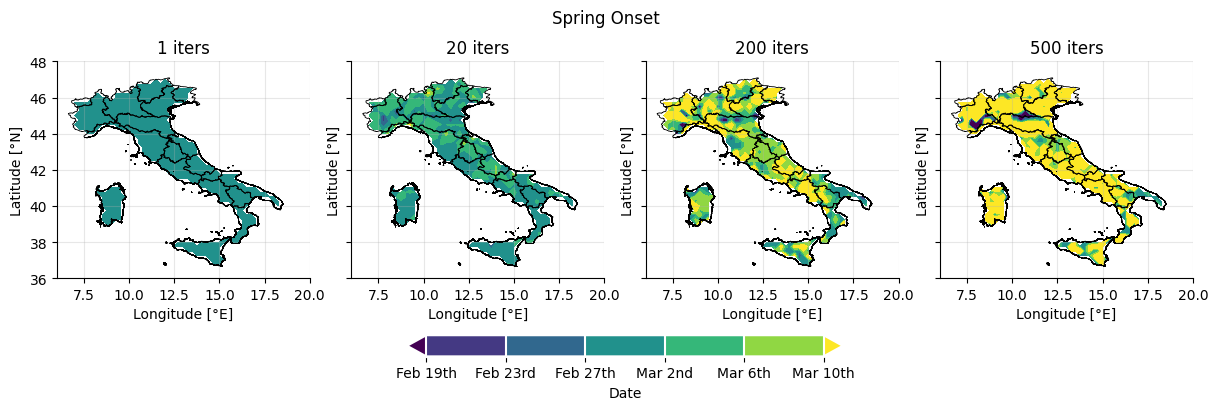

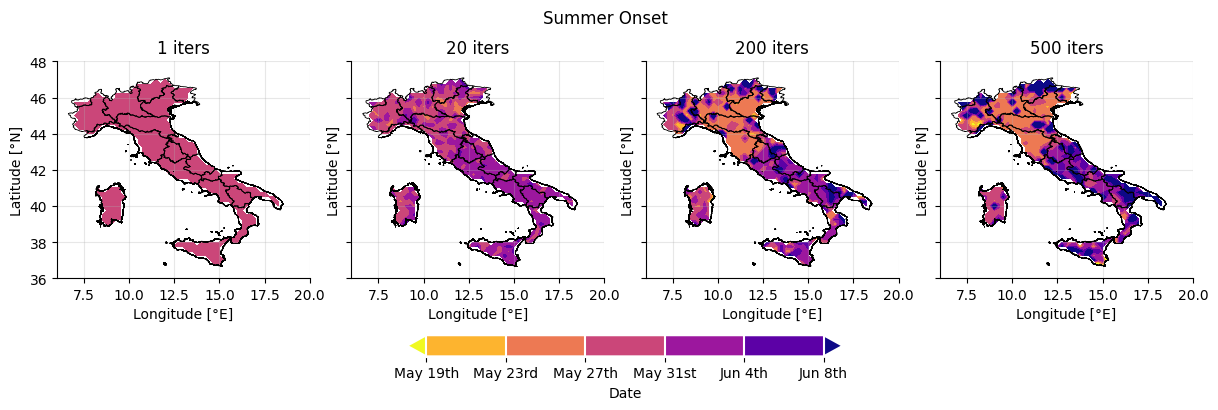

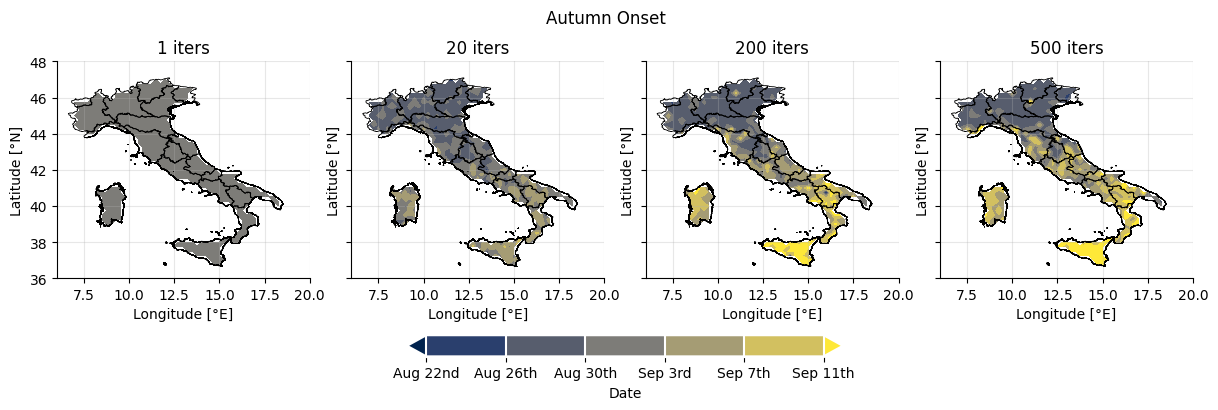

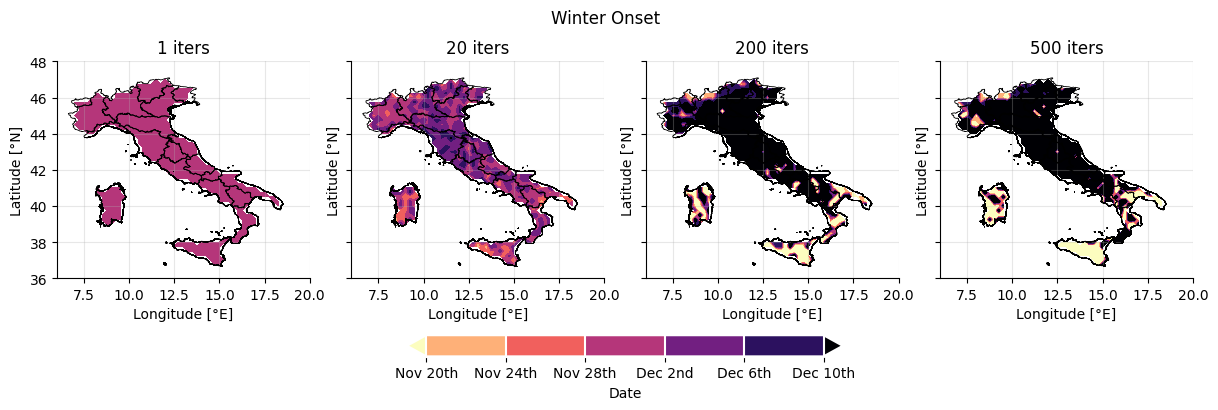

In [18]:
world = gpd.read_file('India/data/gadm_410-levels.gpkg', layer='ADM_0')

for j,title,cmap,s in zip(range(4),['Spring Onset', 'Summer Onset', 'Autumn Onset', 'Winter Onset'],['viridis','plasma_r','cividis','magma_r'],[[50,70], [140,160], [235,255], [325,345]]):
    
    fig, axs = plt.subplots(1,4, figsize=(12, 4), sharey=True, constrained_layout = True)

    to_plt = res.sel(cluster=j)
    lev = np.linspace(s[0],s[1],6)

    for idx, i in enumerate([1,20,200,500]):
        cont_1 = to_plt.t2m.sel(iterations = i).plot.contourf(levels=lev, extend='both',ax=axs[idx], add_colorbar=False, cmap=cmap)
        axs[idx].set_title(f'{i} iters')

    for ax in axs.ravel():
        italy_region.boundary.plot(color = 'k', linewidth = 0.6, label = 'Regioni', ax=ax)
        # Customize the axes
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_xlabel('Longitude [°E]')
        ax.set_ylabel('Latitude [°N]')
        
        
        ax.grid(alpha=0.3)

        # List of neighboring countries to include in the map
        states = ['FRA','CHE', 'HRV','SVN','BIH']
        world.boundary.plot(color='k', linewidth=0.3, ax=ax, alpha=0.5)
        # world.plot(color='gray', alpha=0.3, ax=ax)

        # # Plot boundaries for each neighboring country
        # for state in states:
        # #    world[world.GID_0 == state].boundary.plot(color='k', linewidth=0.3, ax=ax, alpha=0.5)
        #     world[world.GID_0 == state].plot(color='gray', alpha=0.3, ax=ax)

        ax.set_xlim(6,20)
        ax.set_ylim(36,48)


    cbar = plt.colorbar(cont_1, ax=axs.ravel().tolist(), orientation='horizontal',fraction=0.09, drawedges=True)
    cbar.set_ticks(ticks=lev, labels=[day_of_year_to_date(x) for x in lev])

    cbar.outline.set_color('white')
    cbar.outline.set_linewidth(2)
    cbar.dividers.set_color('white')
    cbar.dividers.set_linewidth(1.5)

    fig.suptitle(title)

    cbar.set_label('Date')